## TF-IDF (uni/bi-grams) → Logistic Regression

In [1]:
import helpers as helpers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

from sklearn.model_selection import GridSearchCV, learning_curve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/griffinmichalak/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/griffinmichalak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# TfidfVectorizer(max_features=50k, ngram_range=(1,2), min_df=2) 

DEPRESSION_PATH = "data/depression_dataset_reddit_cleaned.csv"
TDT_SPLIT = "80/10/10"
MODEL_NAME = "tf_idf"

In [3]:
clean_text, is_depression = helpers.get_data(datapath=DEPRESSION_PATH, tokenize=False, by_character=False)

In [4]:
train_text, dev_text, test_text = helpers.split(data=clean_text, dist=TDT_SPLIT)
train_dep, dev_dep, test_dep = helpers.split(data=is_depression, dist=TDT_SPLIT)

Completing 80/10/10 split
Completing 80/10/10 split


In [5]:
# Handles tokenization internally
model = TfidfVectorizer(max_features=50_000, ngram_range=(1,2), min_df=2)
model.fit(train_text)
train_vectors = model.transform(train_text)
dev_vectors = model.transform(dev_text)
test_vectors = model.transform(test_text)

In [6]:
weight = None
# class_weight='balanced'
lr = LogisticRegression(C = 1.0, max_iter=2000, class_weight=weight, solver='liblinear')
lr.fit(train_vectors, train_dep)

dev_predictions = lr.predict(dev_vectors)

In [7]:
precision = precision_score(dev_dep, dev_predictions)
recall = recall_score(dev_dep, dev_predictions)
f1 = f1_score(dev_dep, dev_predictions)
accuracy = accuracy_score(dev_dep, dev_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"Accuracy: {accuracy}")

Precision: 0.9761273209549072
Recall: 0.9387755102040817
F1: 0.9570871261378413
Accuracy: 0.9573091849935317


In [8]:
# tune logistic regression params using the tf_idf vectors we created

estimator = LogisticRegression()

param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'max_iter': [500, 1000, 2000, 5000],
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear']
}

# Grid Search Cross Validation
grid_search = GridSearchCV(estimator, param_grid, scoring='f1', n_jobs=-1)

In [9]:
# fit GridSearchCV on the tf_idf features inside of train_vectors
grid_search.fit(train_vectors, train_dep)

,estimator,LogisticRegression()
,param_grid,"{'C': [0.1, 1, ...], 'class_weight': [None, 'balanced'], 'max_iter': [500, 1000, ...], 'solver': ['liblinear']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [10]:
# gets the best model
grid_search.best_estimator_.score(test_vectors, test_dep)

0.9547803617571059

PR-AUC: 0.9892681845519047
AUC Score: 0.988
Plot saved: results/tf_idf/confusion_tf_idf.png


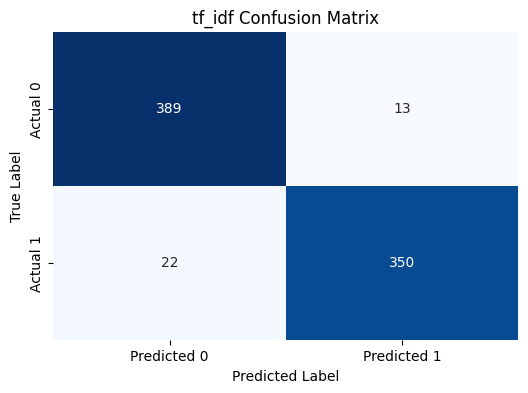

In [11]:
# PR-AUC 
test_probs = grid_search.best_estimator_.predict_proba(test_vectors)[:, 1]
precision_points, recall_points, _ = precision_recall_curve(test_dep, test_probs)
pr_auc = auc(recall_points, precision_points)
print(f"PR-AUC: {pr_auc}")

# ROC-AUC
fpr, tpr, thresholds = roc_curve(test_dep, test_probs)
auc_score = roc_auc_score(test_dep, test_probs)
print(f"AUC Score: {auc_score:.3f}")

# Confusion matrix
test_preds = grid_search.best_estimator_.predict(test_vectors)
cm = confusion_matrix(test_dep, test_preds)

# get test metrics
precision = precision_score(test_dep, test_preds)
recall = recall_score(test_dep, test_preds)
f1 = f1_score(test_dep, test_preds)
accuracy = accuracy_score(test_dep, test_preds)

# show cm
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{MODEL_NAME} Confusion Matrix')

file_name = f"results/{MODEL_NAME}/confusion_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")
    
plt.show()


Plot saved: results/tf_idf/learning_curve_tf_idf.png


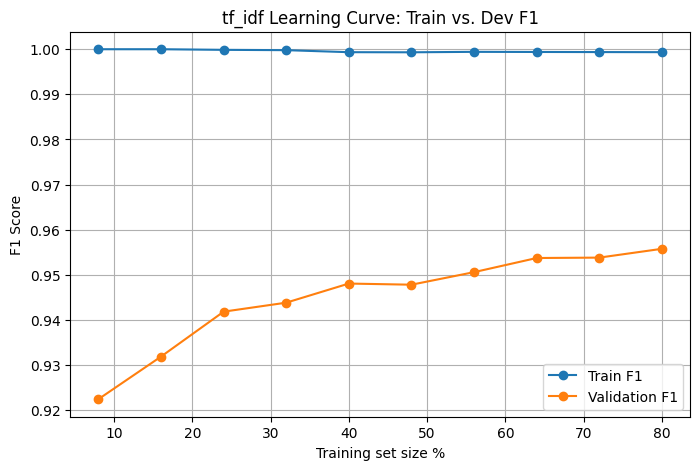

Plot saved: results/tf_idf/pr_tf_idf.png


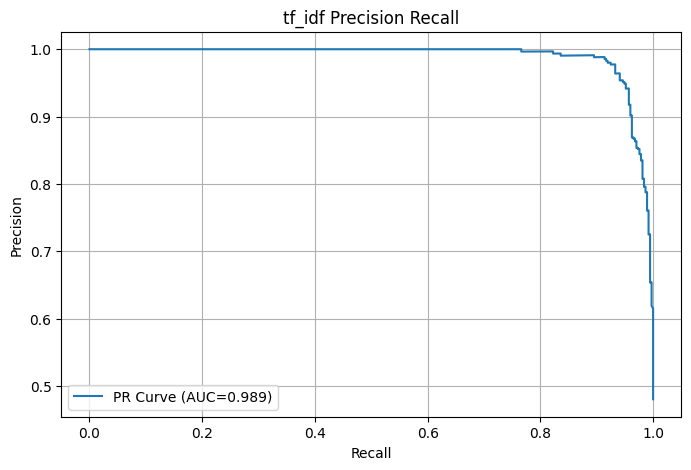

In [12]:
# learning curve
train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_,
    train_vectors,
    train_dep,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes * 100 / train_vectors.shape[0], train_mean, marker='o', label='Train F1')
plt.plot(train_sizes * 100 / train_vectors.shape[0], test_mean, marker='o', label='Validation F1')
plt.xlabel('Training set size %')
plt.ylabel('F1 Score')
plt.title(f'{MODEL_NAME} Learning Curve: Train vs. Dev F1')
plt.legend()
plt.grid(True)

# save graph
file_name = f"results/{MODEL_NAME}/learning_curve_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

# PR graph
precision_points, recall_points, _ = precision_recall_curve(test_dep, test_probs)
pr_auc = auc(recall_points, precision_points)

plt.figure(figsize=(8,5))
plt.plot(recall_points, precision_points, label=f'PR Curve (AUC={pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'{MODEL_NAME} Precision Recall')
plt.legend()
plt.grid(True)

# save graph
file_name = f"results/{MODEL_NAME}/pr_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

In [13]:
# ablation
ngram_configs = [
    (1, 1, "Unigrams only"),
    (2, 2, "Bigrams only"),
    (1, 2, "Unigrams + Bigrams")
]

results = {}
for min_n, max_n, name in ngram_configs:
    model = TfidfVectorizer(max_features=50_000, ngram_range=(min_n, max_n), min_df=2)
    model.fit(train_text)
    train_vectors = model.transform(train_text)
    dev_vectors = model.transform(dev_text)
    
    lr = LogisticRegression(C=1.0, max_iter=2000, solver='liblinear')
    lr.fit(train_vectors, train_dep)
    dev_predictions = lr.predict(dev_vectors)
    
    results[name] = {
        'accuracy': accuracy_score(dev_dep, dev_predictions),
        'f1': f1_score(dev_dep, dev_predictions),
        'precision': precision_score(dev_dep, dev_predictions),
        'recall': recall_score(dev_dep, dev_predictions)
    }


In [14]:
# lastly, save results to csv

csv_file_name = "results/results.csv"
row = [MODEL_NAME, precision, recall, f1, accuracy, pr_auc, auc_score]

helpers.save_to_csv(csv_file_name, row)

Data appended to results/results.csv


## TF-IDF & LR: Most/Least Important Features

In [17]:
best = grid_search.best_estimator_
feature_names = model.get_feature_names_out()
coefficients = best.coef_[0]

k = 10
sorted_coef = np.sort(coefficients)

pos_indices = np.argsort(coefficients)[-k:][::-1]
pos_words = feature_names[pos_indices] # top k words MOST associated with depression

neg_indices = np.argsort(coefficients)[:k]
neg_words = feature_names[neg_indices] # top k words LEAST associated with depression

pos_words

array(['depression', 'anxiety', 'life', 'pression', 'die', 'scared',
       'anymore', 'kill', 'people', 'help'], dtype=object)